In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np; np.set_printoptions(precision=4); np.random.seed(0)
import torch; torch.set_printoptions(precision=4); seed = 1; torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import scipy
import os
import warnings
from sklearn.decomposition import PCA
from textwrap import wrap
from scipy.stats import wilcoxon
from scipy.linalg import subspace_angles

sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from model_working import *
from functions import *
# os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Figure 6a: Example nerual trajectories colored by rule 

(80, 100, 100)
pca of all trajs [9.4567e-01 2.3950e-02 1.6554e-02 4.0968e-03 3.3235e-03 1.6505e-03
 1.0137e-03 8.2777e-04 6.2677e-04 4.0768e-04]


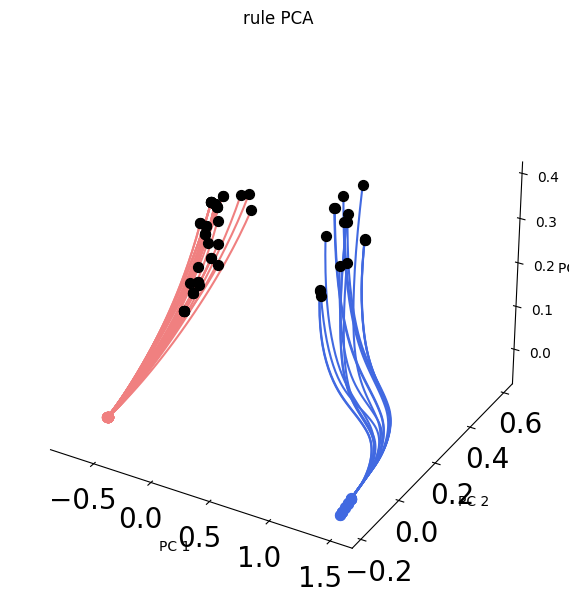

In [10]:
data_fig6a_traj_rule = {'pcx': [], 'pcy': [], 'pcz': []}


for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        # print(model_name)
        if model_name != 'success_2023-05-10-14-28-42_wcst_5_sparsity0':    # this is the example model shown in the paper
            continue
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        
        # load data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()

        # group trials
        trial_labels = label_trials_wcst(test_data=test_data)
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        rule1_trs_after_error = trial_labels['rule1_trs_after_error']
        rule2_trs_after_error = trial_labels['rule2_trs_after_error']
        c1_trs_stable = trial_labels['c1_trs_stable']
        c2_trs_stable = trial_labels['c2_trs_stable']
        c3_trs_stable = trial_labels['c3_trs_stable']
        resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
        error_trials = trial_labels['error_trials']
        stable_trs = rule1_trs_stable + rule2_trs_stable
        
        
        # do PCA over all trajectories
        time_period = np.arange(hp_task_test['trial_history_end']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])    # fdbk + ITI
        neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
        rnn_activity_used = rnn_activity[:, :, :, neuron_used][:, time_period, :, :]   # part of activity used for PCA
        rnn_activity_used = rnn_activity_used[:, :, 0, :]    # squeeze the batch dimension
        print(rnn_activity_used.shape)
        pca_all_traj = PCA(n_components=10)
        rnn_activity_flat = rnn_activity_used.reshape(rnn_activity_used.shape[0]*rnn_activity_used.shape[1], rnn_activity_used.shape[-1])
        pca_all_traj.fit(rnn_activity_flat)
        print('pca of all trajs', pca_all_traj.explained_variance_ratio_)
        
        

        
        
        # plot 3D, rule
        row_idx = 0
        col_idx = 0
        fig, ax = plt.subplots(1, 1, figsize=[6, 6], subplot_kw={'projection': '3d'})
        fig.suptitle('rule PCA')
        fig.patch.set_facecolor('white')
        for tr in range(rnn_activity_used.shape[0]):
            if tr in rule1_trs_stable:
                color = 'royalblue'
            elif tr in rule2_trs_stable:
                color = 'lightcoral'
            else:
                continue
            # rnn_activity_lowd = pca_from_rule.transform(rnn_activity_used[tr, :, :])
            rnn_activity_lowd = pca_all_traj.transform(rnn_activity_used[tr, :, :])
            traj_x, traj_y, traj_z = rnn_activity_lowd[:, 0], rnn_activity_lowd[:, 1], rnn_activity_lowd[:, 2]

            

            ax.plot(traj_x, traj_y, traj_z, color=color)
            ax.scatter(traj_x[-1], traj_y[-1], traj_z[-1], s=50, color=color)
            ax.scatter(traj_x[0], traj_y[0], traj_z[0], s=50, color='k')
            ax.set_xlabel('PC 1')
            ax.set_ylabel('PC 2')
            ax.set_zlabel('PC 3')
                

        make_pretty_axes(ax)
        remove_pane_and_grid_3d(ax)
        fig.tight_layout()
        plt.show()
        fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/fig6a_example_traj_rule.pdf')
                
                


# save to csv
data_fig6a_traj_rule['pcx'] = traj_x
data_fig6a_traj_rule['pcy'] = traj_y
data_fig6a_traj_rule['pcz'] = traj_z
pd.DataFrame.from_dict(data=data_fig6a_traj_rule, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig6a_example_traj_rule.csv', header=False)

# Figure 6b: Example nerual trajectories colored by response 

(80, 50, 100)
PCA % explained variance [0.4517 0.2282 0.0725 0.0525 0.042  0.0285 0.0276 0.0177 0.0148 0.0112]


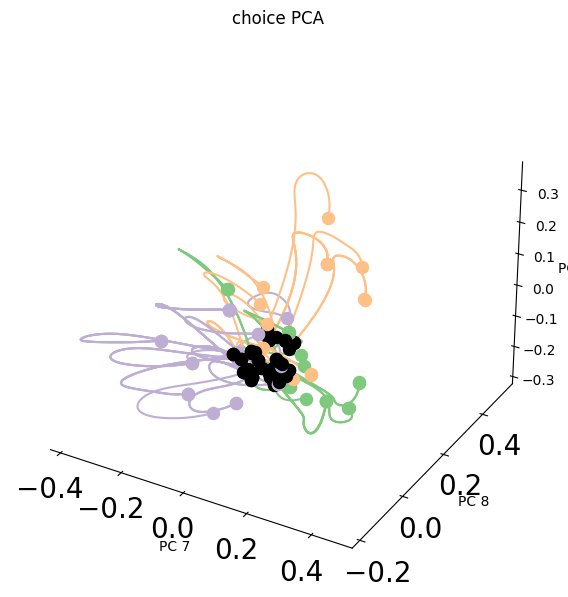

In [16]:
data_fig6b_traj_response = {'x': [], 'y': [], 'z': []}


for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        if model_name != 'success_2023-05-10-14-28-42_wcst_105_sparsity0':    # this is the example model shown in the paper
            continue
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        
        # load data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()

        # group trials
        trial_labels = label_trials_wcst(test_data=test_data)
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        rule1_trs_after_error = trial_labels['rule1_trs_after_error']
        rule2_trs_after_error = trial_labels['rule2_trs_after_error']
        c1_trs_stable = trial_labels['c1_trs_stable']
        c2_trs_stable = trial_labels['c2_trs_stable']
        c3_trs_stable = trial_labels['c3_trs_stable']
        resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
        error_trials = trial_labels['error_trials']
        stable_trs = rule1_trs_stable + rule2_trs_stable
        
        
        
        # do PCA over all trajectories
        time_period = np.arange(hp_task_test['resp_start']//hp_test['dt'], hp_task_test['resp_end']//hp_test['dt'])    # ref card + test cards (response)
        neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
        rnn_activity_used = rnn_activity[:, :, :, neuron_used][:, time_period, :, :]   # part of activity used for PCA
        rnn_activity_used = rnn_activity_used[:, :, 0, :]    # squeeze the batch dimension
        print(rnn_activity_used.shape)
        pca_all_traj = PCA(n_components=10)
        rnn_activity_flat = rnn_activity_used.reshape(rnn_activity_used.shape[0]*rnn_activity_used.shape[1], rnn_activity_used.shape[-1])
        pca_all_traj.fit(rnn_activity_flat)
        print('PCA % explained variance', pca_all_traj.explained_variance_ratio_)
        
                
        # plot 3D, choice
        row_idx = 0
        col_idx = 0
        fig, ax = plt.subplots(1, 1, figsize=[6, 6], subplot_kw={'projection': '3d'})
        fig.suptitle('choice PCA')
        fig.patch.set_facecolor('white')
        for tr in range(rnn_activity_used.shape[0]):
            if tr in c1_trs_stable:
                color = '#7fc97f'
            elif tr in c2_trs_stable:
                color = '#beaed4'
            elif tr in c3_trs_stable:
                color = '#fdc086'
            else:
                continue
            rnn_activity_lowd = pca_all_traj.transform(rnn_activity_used[tr, :, :])
            traj_x, traj_y, traj_z = rnn_activity_lowd[:, 6], rnn_activity_lowd[:, 7], rnn_activity_lowd[:, 8]
            ax.plot(traj_x, traj_y, traj_z, color=color)
            ax.scatter(traj_x[-1], traj_y[-1], traj_z[-1], s=75, color=color)
            ax.scatter(traj_x[0], traj_y[0], traj_z[0], s=75, color='k')
            ax.set_xlabel('PC 7')
            ax.set_ylabel('PC 8')
            ax.set_zlabel('PC 9')
        make_pretty_axes(ax)
        remove_pane_and_grid_3d(ax)
        fig.tight_layout()
        plt.show()
        fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/fig6b_example_traj_response.pdf')
    


# save to csv
data_fig6b_traj_response['x'] = traj_x
data_fig6b_traj_response['y'] = traj_y
data_fig6b_traj_response['z'] = traj_z
pd.DataFrame.from_dict(data=data_fig6b_traj_response, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig6b_example_traj_response.csv', header=False)

In [3]:
# angle_rules = []    # principal angle between rule subspaces
# angle_choices = []    # principal angle between choice subspaces 
# angle_rule_choices = []    # principal angle between rule and choice subspaces
# angle_rules_shuffle = []    # for trial-shuffled data
# angle_choices_shuffle = []    # for trial-shuffled data
# angle_rule_choices_shuffle = []    # for trial-shuffled data
# angle_rules_silencesst = []
# angle_rules_silencepv = []

all_data = {}

d = 'pr'    # number of dimensions for each subspace


for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
        
        
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
    
        if hp_test['dend_nonlinearity'] not in ['subtractive', 'divisive_2']:
            print('filtered')
            continue
            
        # load data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()

        # group trials
        trial_labels = label_trials_wcst(test_data=test_data)
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        rule1_trs_after_error = trial_labels['rule1_trs_after_error']
        rule2_trs_after_error = trial_labels['rule2_trs_after_error']
        c1_trs_stable = trial_labels['c1_trs_stable']
        c2_trs_stable = trial_labels['c2_trs_stable']
        c3_trs_stable = trial_labels['c3_trs_stable']
#         resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
#         error_trials = trial_labels['error_trials']
        stable_trs = rule1_trs_stable + rule2_trs_stable
#         stims = [_[0] for _ in test_data['stims']]
#         ref_cards = [_['center_card'] for _ in stims]
#         ref00trs = [tr for tr in range(len(ref_cards)) if ref_cards[tr]['color']==0 and ref_cards[tr]['shape']==0]
#         ref01trs = [tr for tr in range(len(ref_cards)) if ref_cards[tr]['color']==0 and ref_cards[tr]['shape']==1]
#         ref10trs = [tr for tr in range(len(ref_cards)) if ref_cards[tr]['color']==1 and ref_cards[tr]['shape']==0]
#         ref11trs = [tr for tr in range(len(ref_cards)) if ref_cards[tr]['color']==1 and ref_cards[tr]['shape']==1]
        
        
        
#         # do PCA over all trajectories
# #         time_period = np.arange(hp_task_test['trial_start']//hp_test['dt'], hp_task_test['trial_end']//hp_test['dt'])     # entire trial
#         time_period = np.arange(hp_task_test['trial_start']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])    # fdbk + ITI
# #         time_period = np.arange(hp_task_test['center_card_on']//hp_test['dt'], hp_task_test['test_cards_on']//hp_test['dt'])    # ref card only
# #         time_period = np.arange(hp_task_test['resp_start']//hp_test['dt'], hp_task_test['resp_end']//hp_test['dt'])    # ref card + test cards (response)
#         neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
#         rnn_activity_used = rnn_activity[:, :, :, neuron_used][:, time_period, :, :]   # part of activity used for PCA
#         rnn_activity_used = rnn_activity_used[:, :, 0, :]    # squeeze the batch dimension
#         print(rnn_activity_used.shape)
#         pca_all_traj = PCA(n_components=10)
#         rnn_activity_flat = rnn_activity_used.reshape(rnn_activity_used.shape[0]*rnn_activity_used.shape[1], rnn_activity_used.shape[-1])
#         pca_all_traj.fit(rnn_activity_flat)
#         print('pca of all trajs', pca_all_traj.explained_variance_ratio_)
        
        
        
        
        
        # obtain different subspaces
        # generate subspaces
        neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
        time_used_rule = np.arange(hp_task_test['trial_history_start']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])    # use the inter-trial epoch
#         time_used_rule = np.arange(hp_task_test['center_card_on']//hp_test['dt'], hp_task_test['test_cards_off']//hp_test['dt'])    # use the task epoch
        time_used_choice = np.arange(hp_task_test['resp_start']//hp_test['dt'], hp_task_test['resp_end']//hp_test['dt'])
        
        ## rule 1 subspace
        rnn_activity_sm_rule1 = rnn_activity[rule1_trs_stable, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
        rnn_activity_sm_rule1_flat = rnn_activity_sm_rule1.reshape(rnn_activity_sm_rule1.shape[0]*rnn_activity_sm_rule1.shape[1], rnn_activity_sm_rule1.shape[-1])
        subspace_rule1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_flat, d=d)
        print('exp var ratio of rule 1 subspace:', exp_var_ratio)
        
        ## rule 2 subspace
        rnn_activity_sm_rule2 = rnn_activity[rule2_trs_stable, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
        rnn_activity_sm_rule2_flat = rnn_activity_sm_rule2.reshape(rnn_activity_sm_rule2.shape[0]*rnn_activity_sm_rule2.shape[1], rnn_activity_sm_rule2.shape[-1])
        subspace_rule2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_flat, d=d)
        print('exp var ratio of rule 2 subspace:', exp_var_ratio)
        
        ## choice 1 subspace
        rnn_activity_sm_c1 = rnn_activity[c1_trs_stable, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
        rnn_activity_sm_c1_flat = rnn_activity_sm_c1.reshape(rnn_activity_sm_c1.shape[0]*rnn_activity_sm_c1.shape[1], rnn_activity_sm_c1.shape[-1])
        subspace_c1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c1_flat, d=d)
        print('exp var ratio of choice 1 subspace:', exp_var_ratio)
        
        ## choice 2 subspace
        rnn_activity_sm_c2 = rnn_activity[c2_trs_stable, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
        rnn_activity_sm_c2_flat = rnn_activity_sm_c2.reshape(rnn_activity_sm_c2.shape[0]*rnn_activity_sm_c2.shape[1], rnn_activity_sm_c2.shape[-1])
        subspace_c2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c2_flat, d=d)
        print('exp var ratio of choice 2 subspace:', exp_var_ratio)
        
        ## choice 3 subspace
        rnn_activity_sm_c3 = rnn_activity[c3_trs_stable, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
        rnn_activity_sm_c3_flat = rnn_activity_sm_c3.reshape(rnn_activity_sm_c3.shape[0]*rnn_activity_sm_c3.shape[1], rnn_activity_sm_c3.shape[-1])
        subspace_c3, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c3_flat, d=d)
        print('exp var ratio of choice 3 subspace:', exp_var_ratio)
        
        # rule subspace
        rnn_activity_rule = rnn_activity[stable_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
        rnn_activity_rule_flat = rnn_activity_rule.reshape(rnn_activity_rule.shape[0]*rnn_activity_rule.shape[1], rnn_activity_rule.shape[-1])
        subspace_rule, exp_var_ratio, n_dim = compute_subspace(rnn_activity_rule_flat, d=d)
#         print('exp var ratio of rule subspace:', exp_var_ratio)
        
        # choice subspace
        rnn_activity_choice = rnn_activity[stable_trs, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
        rnn_activity_choice_flat = rnn_activity_choice.reshape(rnn_activity_choice.shape[0]*rnn_activity_choice.shape[1], rnn_activity_choice.shape[-1])
        subspace_choice, exp_var_ratio, n_dim = compute_subspace(rnn_activity_choice_flat, d=d)
#         print('exp var ratio of choice subspace:', exp_var_ratio)
        
        # compute angle between subspaces
        angle_rule_subspace = np.rad2deg(subspace_angles(subspace_rule1.T, subspace_rule2.T)[0])
        angle_choice12_subspace = np.rad2deg(subspace_angles(subspace_c1.T, subspace_c2.T)[0])
        angle_choice13_subspace = np.rad2deg(subspace_angles(subspace_c1.T, subspace_c3.T)[0])
        angle_choice23_subspace = np.rad2deg(subspace_angles(subspace_c2.T, subspace_c3.T)[0])
        angle_choice_subspace_avg = np.mean([angle_choice12_subspace, angle_choice13_subspace, angle_choice23_subspace])
        angle_rule_choice = np.rad2deg(subspace_angles(subspace_rule.T, subspace_choice.T)[0])
        
        
        # Do the same for shuffled data
        angle_rules_shuffle = []
        angle_choices_shuffle = []
        angle_rule_choices_shuffle = []
        
        for _ in range(100):
            # generate shuffled trials
            rule_trs_stable = rule1_trs_stable + rule2_trs_stable
            rule1_trs_stable_shuffle = np.random.choice(rule_trs_stable, size=len(rule_trs_stable)//2, replace=False)
            rule2_trs_stable_shuffle = [tr for tr in rule_trs_stable if tr not in rule1_trs_stable_shuffle]
            ## another way: split trials within each rule
            rule1_trs_split1 = np.random.choice(rule1_trs_stable, size=len(rule1_trs_stable)//2, replace=False)
            rule1_trs_split2 = [tr for tr in rule1_trs_stable if tr not in rule1_trs_split1]
            rule2_trs_split1 = np.random.choice(rule2_trs_stable, size=len(rule2_trs_stable)//2, replace=False)
            rule2_trs_split2 = [tr for tr in rule2_trs_stable if tr not in rule2_trs_split1]
            
            choice_trs_stable = c1_trs_stable + c2_trs_stable + c3_trs_stable
            np.random.shuffle(choice_trs_stable)
            c1_trs_stable_shuffle = choice_trs_stable[:len(choice_trs_stable)//3]
            c2_trs_stable_shuffle = choice_trs_stable[len(choice_trs_stable)//3 : len(choice_trs_stable)//3*2]
            c3_trs_stable_shuffle = choice_trs_stable[len(choice_trs_stable)//3*2 : len(choice_trs_stable)]
            ## another way: split trials within each choice
            c1_trs_split1 = np.random.choice(c1_trs_stable, size=len(c1_trs_stable)//2, replace=False)
            c1_trs_split2 = [tr for tr in c1_trs_stable if tr not in c1_trs_split1]
            c2_trs_split1 = np.random.choice(c2_trs_stable, size=len(c2_trs_stable)//2, replace=False)
            c2_trs_split2 = [tr for tr in c2_trs_stable if tr not in c2_trs_split1]
            c3_trs_split1 = np.random.choice(c3_trs_stable, size=len(c3_trs_stable)//2, replace=False)
            c3_trs_split2 = [tr for tr in c3_trs_stable if tr not in c3_trs_split1]

            # generate subspaces
            ## rule 1 subspace
#             rnn_activity_sm_rule1_shuffle = rnn_activity[rule1_trs_stable_shuffle, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
#             rnn_activity_sm_rule1_flat_shuffle = rnn_activity_sm_rule1_shuffle.reshape(rnn_activity_sm_rule1_shuffle.shape[0]*rnn_activity_sm_rule1_shuffle.shape[1], rnn_activity_sm_rule1_shuffle.shape[-1])
#             subspace_rule1_shuffle, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_flat_shuffle, d=d)
#             if _==0:
#                 print('exp var ratio of rule 1 subspace (shuffle):', exp_var_ratio)
            ### another way, split trials within each rule
            rnn_activity_sm_rule1_split1 = rnn_activity[rule1_trs_split1, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule1_split1 = rnn_activity_sm_rule1_split1.reshape(rnn_activity_sm_rule1_split1.shape[0]*rnn_activity_sm_rule1_split1.shape[1], rnn_activity_sm_rule1_split1.shape[-1])
            subspace_rule1_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_split1, d=d)
            if _==0:
                print('exp var ratio of rule 1 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_rule1_split2 = rnn_activity[rule1_trs_split2, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule1_split2 = rnn_activity_sm_rule1_split2.reshape(rnn_activity_sm_rule1_split2.shape[0]*rnn_activity_sm_rule1_split2.shape[1], rnn_activity_sm_rule1_split2.shape[-1])
            subspace_rule1_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_split2, d=d)
            if _==0:
                print('exp var ratio of rule 1 subspace (split2):', exp_var_ratio)
            
            

            ## rule 2 subspace
#             rnn_activity_sm_rule2_shuffle = rnn_activity[rule2_trs_stable_shuffle, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
#             rnn_activity_sm_rule2_flat_shuffle = rnn_activity_sm_rule2_shuffle.reshape(rnn_activity_sm_rule2_shuffle.shape[0]*rnn_activity_sm_rule2_shuffle.shape[1], rnn_activity_sm_rule2_shuffle.shape[-1])
#             subspace_rule2_shuffle, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_flat_shuffle, d=d)
#             if _==0:
#                 print('exp var ratio of rule 2 subspace (shuffle):', exp_var_ratio)
            ### another way, split trials within each rule
            rnn_activity_sm_rule2_split1 = rnn_activity[rule2_trs_split1, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule2_split1 = rnn_activity_sm_rule2_split1.reshape(rnn_activity_sm_rule2_split1.shape[0]*rnn_activity_sm_rule2_split1.shape[1], rnn_activity_sm_rule2_split1.shape[-1])
            subspace_rule2_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_split1, d=d)
            if _==0:
                print('exp var ratio of rule 2 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_rule2_split2 = rnn_activity[rule2_trs_split2, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule2_split2 = rnn_activity_sm_rule2_split2.reshape(rnn_activity_sm_rule2_split2.shape[0]*rnn_activity_sm_rule2_split2.shape[1], rnn_activity_sm_rule2_split2.shape[-1])
            subspace_rule2_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_split2, d=d)
            if _==0:
                print('exp var ratio of rule 2 subspace (split2):', exp_var_ratio)

                
                
            ## choice 1 subspace
#             rnn_activity_sm_c1_shuffle = rnn_activity[c1_trs_stable_shuffle, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
#             rnn_activity_sm_c1_flat_shuffle = rnn_activity_sm_c1_shuffle.reshape(rnn_activity_sm_c1_shuffle.shape[0]*rnn_activity_sm_c1_shuffle.shape[1], rnn_activity_sm_c1_shuffle.shape[-1])
#             subspace_c1_shuffle, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c1_flat_shuffle, d=d)
#             if _==0:
#                 print('exp var ratio of choice 1 subspace (shuffle):', exp_var_ratio)
            ### another way, split trials within each choice
            rnn_activity_sm_c1_split1 = rnn_activity[c1_trs_split1, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c1_split1 = rnn_activity_sm_c1_split1.reshape(rnn_activity_sm_c1_split1.shape[0]*rnn_activity_sm_c1_split1.shape[1], rnn_activity_sm_c1_split1.shape[-1])
            subspace_c1_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c1_split1, d=d)
            if _==0:
                print('exp var ratio of choice 1 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_c1_split2 = rnn_activity[c1_trs_split2, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c1_split2 = rnn_activity_sm_c1_split2.reshape(rnn_activity_sm_c1_split2.shape[0]*rnn_activity_sm_c1_split2.shape[1], rnn_activity_sm_c1_split2.shape[-1])
            subspace_c1_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c1_split2, d=d)
            if _==0:
                print('exp var ratio of choice 1 subspace (split2):', exp_var_ratio)
                
            ## choice 2 subspace
#             rnn_activity_sm_c2_shuffle = rnn_activity[c2_trs_stable_shuffle, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
#             rnn_activity_sm_c2_flat_shuffle = rnn_activity_sm_c2_shuffle.reshape(rnn_activity_sm_c2_shuffle.shape[0]*rnn_activity_sm_c2_shuffle.shape[1], rnn_activity_sm_c2_shuffle.shape[-1])
#             subspace_c2_shuffle, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c2_flat_shuffle, d=d)
#             if _==0:
#                 print('exp var ratio of choice 2 subspace (shuffle):', exp_var_ratio)
            ### another way, split trials within each choice
            rnn_activity_sm_c2_split1 = rnn_activity[c2_trs_split1, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c2_split1 = rnn_activity_sm_c2_split1.reshape(rnn_activity_sm_c2_split1.shape[0]*rnn_activity_sm_c2_split1.shape[1], rnn_activity_sm_c2_split1.shape[-1])
            subspace_c2_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c2_split1, d=d)
            if _==0:
                print('exp var ratio of choice 2 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_c2_split2 = rnn_activity[c2_trs_split2, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c2_split2 = rnn_activity_sm_c2_split2.reshape(rnn_activity_sm_c2_split2.shape[0]*rnn_activity_sm_c2_split2.shape[1], rnn_activity_sm_c2_split2.shape[-1])
            subspace_c2_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c2_split2, d=d)
            if _==0:
                print('exp var ratio of choice 2 subspace (split2):', exp_var_ratio)

                
            ## choice 3 subspace
#             rnn_activity_sm_c3_shuffle = rnn_activity[c3_trs_stable_shuffle, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
#             rnn_activity_sm_c3_flat_shuffle = rnn_activity_sm_c3_shuffle.reshape(rnn_activity_sm_c3_shuffle.shape[0]*rnn_activity_sm_c3_shuffle.shape[1], rnn_activity_sm_c3_shuffle.shape[-1])
#             subspace_c3_shuffle, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c3_flat_shuffle, d=d)
#             if _==0:
#                 print('exp var ratio of choice 3 subspace (shuffle):', exp_var_ratio)
            ### another way, split trials within each choice
            rnn_activity_sm_c3_split1 = rnn_activity[c3_trs_split1, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c3_split1 = rnn_activity_sm_c3_split1.reshape(rnn_activity_sm_c3_split1.shape[0]*rnn_activity_sm_c3_split1.shape[1], rnn_activity_sm_c3_split1.shape[-1])
            subspace_c3_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c3_split1, d=d)
            if _==0:
                print('exp var ratio of choice 3 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_c3_split2 = rnn_activity[c3_trs_split2, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c3_split2 = rnn_activity_sm_c3_split2.reshape(rnn_activity_sm_c3_split2.shape[0]*rnn_activity_sm_c3_split2.shape[1], rnn_activity_sm_c3_split2.shape[-1])
            subspace_c3_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c3_split2, d=d)
            if _==0:
                print('exp var ratio of choice 3 subspace (split2):', exp_var_ratio)
                
                
                
                
            ## rule and choice subspaces
#             rnn_activity_rule_and_choice = np.concatenate((rnn_activity_rule, rnn_activity_choice), axis=1)
#             n_ts_rule = rnn_activity_rule.shape[1]    # number of timesteps in the rule activity
#             n_ts_choice = rnn_activity_choice.shape[1]    # number of timesteps in the choice activity
#             ts_rule_shuffle = np.random.choice(np.arange(n_ts_rule+n_ts_choice), n_ts_rule)
#             ts_choice_suffle = [t for t in range(n_ts_rule+n_ts_choice) if t not in ts_rule_shuffle]
#             rnn_activity_rule_shuffle = rnn_activity_rule_and_choice[:, ts_rule_shuffle, :]
#             rnn_activity_choice_shuffle = rnn_activity_rule_and_choice[:, ts_choice_suffle, :]
#             rnn_activity_rule_shuffle_flat = rnn_activity_rule_shuffle.reshape(rnn_activity_rule_shuffle.shape[0]*rnn_activity_rule_shuffle.shape[1], rnn_activity_rule_shuffle.shape[-1])
#             rnn_activity_choice_shuffle_flat = rnn_activity_choice_shuffle.reshape(rnn_activity_choice_shuffle.shape[0]*rnn_activity_choice_shuffle.shape[1], rnn_activity_choice_shuffle.shape[-1])
            
#             subspace_rule_shuffle, exp_var_ratio, n_dim = compute_subspace(rnn_activity_rule_shuffle_flat, d=d)
#             subspace_choice_shuffle, exp_var_ratio, n_dim = compute_subspace(rnn_activity_choice_shuffle_flat, d=d)

            ### another way: split trials separately for rule and choice
            rule_trs_stable = rule1_trs_stable + rule2_trs_stable
            rule_trs_split1 = np.random.choice(rule_trs_stable, size=len(rule_trs_stable)//2, replace=False)
            rule_trs_split2 = [tr for tr in rule_trs_stable if tr not in rule_trs_split1]
            
            choice_trs_stable = c1_trs_stable + c2_trs_stable + c3_trs_stable
            choice_trs_split1 = np.random.choice(choice_trs_stable, size=len(choice_trs_stable)//2, replace=False)
            choice_trs_split2 = [tr for tr in choice_trs_stable if tr not in choice_trs_split1]
            
            rnn_activity_rule_split1 = rnn_activity[rule_trs_split1, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_rule_split2 = rnn_activity[rule_trs_split2, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_rule_split1_flat = rnn_activity_rule_split1.reshape(rnn_activity_rule_split1.shape[0]*rnn_activity_rule_split1.shape[1], rnn_activity_rule_split1.shape[-1])
            rnn_activity_rule_split2_flat = rnn_activity_rule_split2.reshape(rnn_activity_rule_split2.shape[0]*rnn_activity_rule_split2.shape[1], rnn_activity_rule_split2.shape[-1])
            
            rnn_activity_choice_split1 = rnn_activity[choice_trs_split1, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_choice_split2 = rnn_activity[choice_trs_split2, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_choice_split1_flat = rnn_activity_choice_split1.reshape(rnn_activity_choice_split1.shape[0]*rnn_activity_choice_split1.shape[1], rnn_activity_choice_split1.shape[-1])
            rnn_activity_choice_split2_flat = rnn_activity_choice_split2.reshape(rnn_activity_choice_split2.shape[0]*rnn_activity_choice_split2.shape[1], rnn_activity_choice_split2.shape[-1])
            
            subspace_rule_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_rule_split1_flat, d=d)
            subspace_rule_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_rule_split2_flat, d=d)
            subspace_choice_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_choice_split1_flat, d=d)
            subspace_choice_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_choice_split2_flat, d=d)
            
            
            
        
            # compute angle between subspaces
#             angle_rule_subspace_shuffle = np.rad2deg(subspace_angles(subspace_rule1_shuffle.T, subspace_rule2_shuffle.T)[0])
#             angle_choice12_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c1_shuffle.T, subspace_c2_shuffle.T)[0])
#             angle_choice13_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c1_shuffle.T, subspace_c3_shuffle.T)[0])
#             angle_choice23_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c2_shuffle.T, subspace_c3_shuffle.T)[0])
#             angle_choice_subspace_avg_shuffle = np.mean([angle_choice12_subspace_shuffle, angle_choice13_subspace_shuffle, angle_choice23_subspace_shuffle])
#             angle_rule_choice_subspace_shuffle = np.rad2deg(subspace_angles(subspace_rule_shuffle.T, subspace_choice_shuffle.T)[0])
            
            ## another way
            angle_rule1_subspace_shuffle = np.rad2deg(subspace_angles(subspace_rule1_split1.T, subspace_rule1_split2.T)[0])
            angle_rule2_subspace_shuffle = np.rad2deg(subspace_angles(subspace_rule2_split1.T, subspace_rule2_split2.T)[0])
            angle_rule_subspace_shuffle = np.mean([angle_rule1_subspace_shuffle, angle_rule2_subspace_shuffle])
            
            angle_c1_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c1_split1.T, subspace_c1_split2.T)[0])
            angle_c2_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c2_split1.T, subspace_c2_split2.T)[0])
            angle_c3_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c3_split1.T, subspace_c3_split2.T)[0])
            angle_choice_subspace_avg_shuffle = np.mean([angle_c1_subspace_shuffle, angle_c2_subspace_shuffle, angle_c3_subspace_shuffle])
            
            angle_rule_subspace_shuffle = np.rad2deg(subspace_angles(subspace_rule_split1.T, subspace_rule_split2.T )[0])
            angle_choice_subspace_shuffle = np.rad2deg(subspace_angles(subspace_choice_split1.T, subspace_choice_split2.T)[0])
            angle_rule_choice_subspace_shuffle = np.mean([angle_rule_subspace_shuffle, angle_choice_subspace_shuffle])

            # append to the list
            angle_rules_shuffle.append(angle_rule_subspace_shuffle)
            angle_choices_shuffle.append(angle_choice_subspace_avg_shuffle)
            angle_rule_choices_shuffle.append(angle_rule_choice_subspace_shuffle)
            
            
        
        
        

        
        

        
        # collect data
        all_data[model_name] = {'model_name': model_name,
                               'hp': hp_test,
                               'angle_rule_subspace': angle_rule_subspace,
                               'angle_rule_subspace_shuffle': angle_rules_shuffle,
                               'angle_choice_subspace_avg': angle_choice_subspace_avg,
                               'angle_choice_subspace_avg_shuffle': angle_choices_shuffle,
                               'angle_rule_choice': angle_rule_choice,
                               'angle_rule_choice_shuffle': angle_rule_choices_shuffle
                               }







            
        
            
        

success_2023-05-10-14-28-42_wcst_105_sparsity0
exp var ratio of rule 1 subspace: [0.85]
exp var ratio of rule 2 subspace: [0.67 0.24]
exp var ratio of choice 1 subspace: [0.55 0.23 0.09]
exp var ratio of choice 2 subspace: [0.4  0.27 0.17 0.05]
exp var ratio of choice 3 subspace: [0.46 0.25 0.13]
exp var ratio of rule 1 subspace (split1): [0.85]
exp var ratio of rule 1 subspace (split2): [0.85]
exp var ratio of rule 2 subspace (split1): [0.67 0.24]
exp var ratio of rule 2 subspace (split2): [0.68 0.24]
exp var ratio of choice 1 subspace (split1): [0.58 0.22 0.07]
exp var ratio of choice 1 subspace (split2): [0.54 0.23 0.1 ]
exp var ratio of choice 2 subspace (split1): [0.48 0.24 0.14]
exp var ratio of choice 2 subspace (split2): [0.39 0.26 0.2  0.06]
exp var ratio of choice 3 subspace (split1): [0.48 0.25 0.12]
exp var ratio of choice 3 subspace (split2): [0.47 0.26 0.13]
success_2023-05-10-14-28-42_wcst_106_sparsity0
exp var ratio of rule 1 subspace: [0.91]
exp var ratio of rule 2 sub

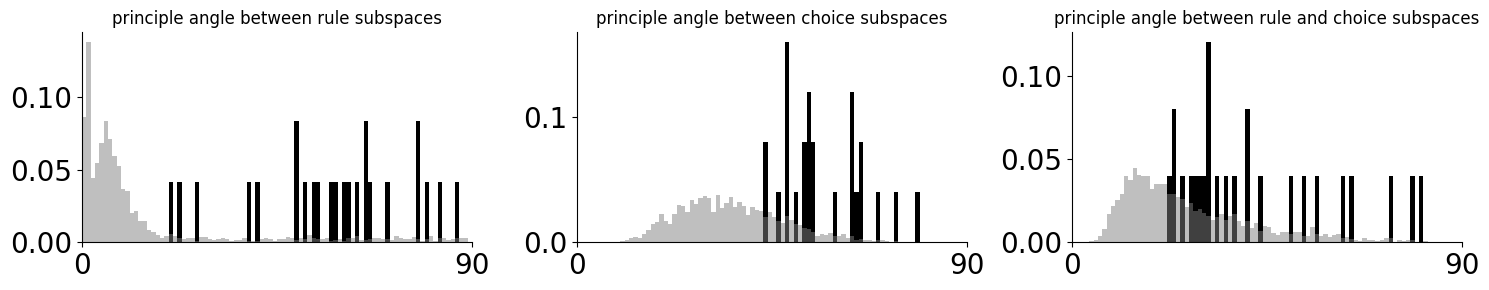

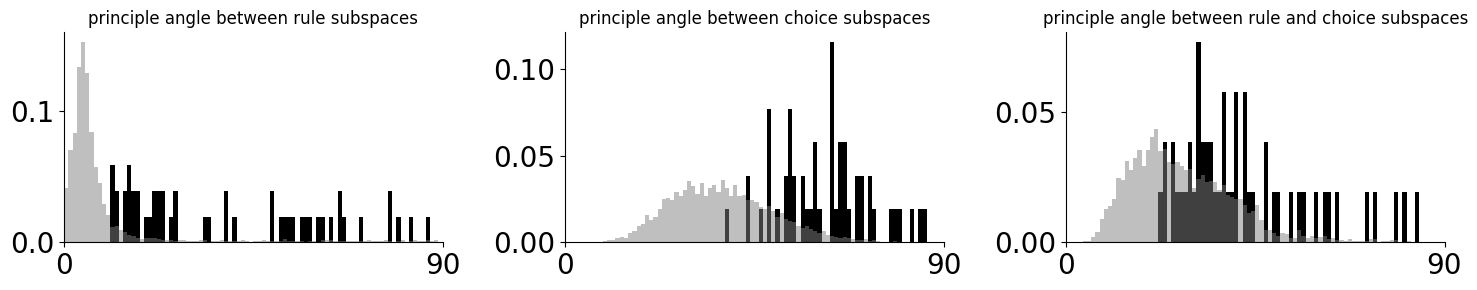

In [5]:
angle_rules_all_models = []
angle_rules_all_models_shuffle = []
angle_choices_all_models = []
angle_choices_all_models_shuffle = []
angle_rule_choice_all_models = []
angle_rule_choice_all_models_shuffle = []

model_list = list(all_data.keys())
for dend_nonlinearity in ['subtractive', 'divisive_2']:
    for model in model_list:
        if all_data[model]['hp']['dend_nonlinearity'] != dend_nonlinearity:
            continue
        angle_rules_all_models.append(all_data[model]['angle_rule_subspace'])
        angle_rules_all_models_shuffle.extend(all_data[model]['angle_rule_subspace_shuffle'])
        angle_choices_all_models.append(all_data[model]['angle_choice_subspace_avg'])
        angle_choices_all_models_shuffle.extend(all_data[model]['angle_choice_subspace_avg_shuffle'])
        angle_rule_choice_all_models.append(all_data[model]['angle_rule_choice'])
        angle_rule_choice_all_models_shuffle.extend(all_data[model]['angle_rule_choice_shuffle'])
    
    # subspace angle compare to shuffled data
    fig, ax = plt.subplots(1, 3, figsize=[15, 3])
    bins=np.arange(0, 90, 1)
    ax[0].set_title('principle angle between rule subspaces')
    ax[1].set_title('principle angle between choice subspaces')
    ax[2].set_title('principle angle between rule and choice subspaces')
    
    ax[0].hist(angle_rules_all_models, color='k', density=True, bins=bins)
    ax[0].hist(angle_rules_all_models_shuffle, color='gray', alpha=0.5, density=True, bins=bins)
    # ax[0].hist(angle_rules_silencesst, color='red')
    
    ax[1].hist(angle_choices_all_models, color='k', density=True, bins=bins)
    ax[1].hist(angle_choices_all_models_shuffle, color='gray', alpha=0.5, density=True, bins=bins)
    # ax[1].hist(angle_choices_silencesst, color='red')
    
    ax[2].hist(angle_rule_choice_all_models, color='k', density=True, bins=bins)
    ax[2].hist(angle_rule_choice_all_models_shuffle, color='gray', alpha=0.5, density=True, bins=bins)
    for i in range(3):
        make_pretty_axes(ax[i])
        ax[i].set_xlim([0, 90])
        ax[i].set_xticks([0, 90])
    fig.tight_layout()
    plt.show()

    if dend_nonlinearity == 'subtractive':
        data_fig6cd = {'rule': angle_rules_all_models, 'rule_shuffle': angle_rules_all_models_shuffle, 'response': angle_choices_all_models, 'response_shuffle': angle_choices_all_models_shuffle}
    elif dend_nonlinearity == 'divisive_2':
        data_suppfig10ab = {'rule': angle_rules_all_models, 'rule_shuffle': angle_rules_all_models_shuffle, 'response': angle_choices_all_models, 'response_shuffle': angle_choices_all_models_shuffle}

In [33]:
# save to csv
pd.DataFrame.from_dict(data=data_fig6cd, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig6cd.csv', header=False)
pd.DataFrame.from_dict(data=data_suppfig10ab, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig10ab.csv', header=False)

In [37]:
d = 'pr'

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
        
        if model_name not in list(all_data.keys()):
            print('model perf is low, excluded in previous analysis, skip')
            continue
            
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        
        if hp_test['dend_nonlinearity'] not in ['subtractive', 'divisive_2']:
            print('filtered')
            continue
            
        # subspace with SST silenced
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_silenceSRSST_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
#         if mean_perf<0.05 or mean_perf_rule<0.05:
#             print('prob ({}/{})'.format(mean_perf, mean_perf_rule))
#             continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
    
        if np.isnan(rnn_activity).any():
            print('NAN in rnn_activity')
            angle_rule_subspace_nosst = np.nan
        else:
            # group trials
            trial_labels = label_trials_wcst(test_data=test_data)
            rule1_trs = trial_labels['rule1_trs']
            rule2_trs = trial_labels['rule2_trs']
            c1_trs = trial_labels['c1_trs']
            c2_trs = trial_labels['c2_trs']
            c3_trs = trial_labels['c3_trs']
    #         if len(c1_trs)==0 or len(c2_trs)==0 or len(c3_trs)==0:
    #             print('no trials for certain choice: {}/{}/{}'.format(len(c1_trs), len(c2_trs), len(c3_trs)))
    #             continue
    #         resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
            error_trials = trial_labels['error_trials']

            # generate subspaces
            neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
            time_used_rule = np.arange(hp_task_test['trial_history_start']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])
            time_used_choice = np.arange(hp_task_test['resp_start']//hp_test['dt'], hp_task_test['resp_end']//hp_test['dt'])

            ## rule 1 subspace
            rnn_activity_sm_rule1 = rnn_activity[rule1_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule1_flat = rnn_activity_sm_rule1.reshape(rnn_activity_sm_rule1.shape[0]*rnn_activity_sm_rule1.shape[1], rnn_activity_sm_rule1.shape[-1])
#             pca = PCA(n_components=d)
#             pca.fit(rnn_activity_sm_rule1_flat)
#             print('rule1 subspace exp var: {}'.format(pca.explained_variance_ratio_))
#             subspace_rule1_nosst = pca.components_
            subspace_rule1_nosst, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_flat, d=d)
            print('exp var ratio of rule 1 subspace (silence SST):', exp_var_ratio)

            ## rule 2 subspace
            rnn_activity_sm_rule2 = rnn_activity[rule2_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule2_flat = rnn_activity_sm_rule2.reshape(rnn_activity_sm_rule2.shape[0]*rnn_activity_sm_rule2.shape[1], rnn_activity_sm_rule2.shape[-1])
#             pca = PCA(n_components=d)
#             pca.fit(rnn_activity_sm_rule2_flat)
#             print('rule2 subspace exp var: {}'.format(pca.explained_variance_ratio_))
#             subspace_rule2_nosst = pca.components_
            subspace_rule2_nosst, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_flat, d=d)
            print('exp var ratio of rule 2 subspace (silence SST):', exp_var_ratio)
        
            # compute angle between subspaces
            angle_rule_subspace_nosst = np.rad2deg(subspace_angles(subspace_rule1_nosst.T, subspace_rule2_nosst.T)[0])

            # append to the big list
    #         angle_rules_silencesst.append(angle_rule_subspace)
    #         angle_choices_silencesst.append(angle_choice_subspace_avg)



        
#         # subspace with PV silenced
#         with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_silenceSRPV_noiseless_no_current_matrix'), 'rb') as f:
#             neural_data = pickle.load(f)
#         test_data = neural_data['test_data']
#         mean_perf = np.mean([_[0] for _ in test_data['perfs']])
#         mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
# #         if mean_perf<0.05 or mean_perf_rule<0.05:
# #             print('prob ({}/{})'.format(mean_perf, mean_perf_rule))
# #             continue
#         rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
    
#         if np.isnan(rnn_activity).any():
#             print('NAN in rnn_activity')
#             angle_rule_subspace_nopv = np.nan
#         else:
#             # group trials
#             trial_labels = label_trials_wcst(test_data=test_data)
#             rule1_trs = trial_labels['rule1_trs']
#             rule2_trs = trial_labels['rule2_trs']
#             c1_trs = trial_labels['c1_trs']
#             c2_trs = trial_labels['c2_trs']
#             c3_trs = trial_labels['c3_trs']
#     #         if len(c1_trs)==0 or len(c2_trs)==0 or len(c3_trs)==0:
#     #             print('no trials for certain choice: {}/{}/{}'.format(len(c1_trs), len(c2_trs), len(c3_trs)))
#     #             continue
#     #         resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
#             error_trials = trial_labels['error_trials']

#             # generate subspaces
#             neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
#             time_used_rule = np.arange(hp_task_test['trial_history_start']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])
#             time_used_choice = np.arange(hp_task_test['resp_start']//hp_test['dt'], hp_task_test['resp_end']//hp_test['dt'])

#             ## rule 1 subspace
#             rnn_activity_sm_rule1 = rnn_activity[rule1_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
#             rnn_activity_sm_rule1_flat = rnn_activity_sm_rule1.reshape(rnn_activity_sm_rule1.shape[0]*rnn_activity_sm_rule1.shape[1], rnn_activity_sm_rule1.shape[-1])
# #             pca = PCA(n_components=d)
# #             pca.fit(rnn_activity_sm_rule1_flat)
# #             print('rule1 subspace exp var: {}'.format(pca.explained_variance_ratio_))
# #             subspace_rule1_nopv = pca.components_
#             subspace_rule1_nopv, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_flat, d=d)
#             print('exp var ratio of rule 1 subspace (silence PV):', exp_var_ratio)
            
#             ## rule 2 subspace
#             rnn_activity_sm_rule2 = rnn_activity[rule2_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
#             rnn_activity_sm_rule2_flat = rnn_activity_sm_rule2.reshape(rnn_activity_sm_rule2.shape[0]*rnn_activity_sm_rule2.shape[1], rnn_activity_sm_rule2.shape[-1])
# #             pca = PCA(n_components=d)
# #             pca.fit(rnn_activity_sm_rule2_flat)
# #             print('rule2 subspace exp var: {}'.format(pca.explained_variance_ratio_))
# #             subspace_rule2_nopv = pca.components_
#             subspace_rule2_nopv, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_flat, d=d)
#             print('exp var ratio of rule 2 subspace (silence PV):', exp_var_ratio)

#             # compute angle between subspaces
#             angle_rule_subspace_nopv = np.rad2deg(subspace_angles(subspace_rule1_nopv.T, subspace_rule2_nopv.T)[0])

            # append to the big list
    #         angle_rules_silencepv.append(angle_rule_subspace_nopv)
    #         angle_choices_silencesst.append(angle_choice_subspace_avg)
    
    
    
        # add to the data dict
        # all_data[model_name]['angle_rule_subspace_nopv'] = angle_rule_subspace_nopv
        all_data[model_name]['angle_rule_subspace_nosst'] = angle_rule_subspace_nosst
       

success_2023-05-10-14-28-42_wcst_105_sparsity0
exp var ratio of rule 1 subspace (silence SST): [0.64 0.31]
exp var ratio of rule 2 subspace (silence SST): [0.99]
success_2023-05-10-14-28-42_wcst_106_sparsity0
NAN in rnn_activity
success_2023-05-10-14-28-42_wcst_10_sparsity0
exp var ratio of rule 1 subspace (silence SST): [0.65 0.21]
exp var ratio of rule 2 subspace (silence SST): [0.63 0.27]
success_2023-05-10-14-28-42_wcst_112_sparsity0
model perf is low, excluded in previous analysis, skip
success_2023-05-10-14-28-42_wcst_115_sparsity0
model perf is low, excluded in previous analysis, skip
success_2023-05-10-14-28-42_wcst_116_sparsity0
exp var ratio of rule 1 subspace (silence SST): [0.86]
exp var ratio of rule 2 subspace (silence SST): [0.86]
success_2023-05-10-14-28-42_wcst_118_sparsity0
exp var ratio of rule 1 subspace (silence SST): [0.98]
exp var ratio of rule 2 subspace (silence SST): [0.84]
success_2023-05-10-14-28-42_wcst_121_sparsity0
exp var ratio of rule 1 subspace (silenc

subtractive


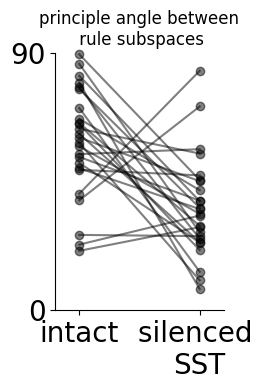

Ttest_indResult(statistic=4.430784783334216, pvalue=2.7139162327148595e-05)
n=25
divisive_2


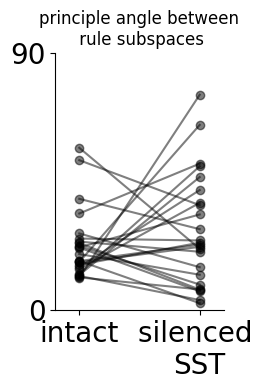

Ttest_indResult(statistic=-1.0974057125718801, pvalue=0.8609122122537016)
n=24


In [42]:
# plot
data_fig7f = {}
data_suppfig11c = {}

for dend_nonlinear in ['subtractive', 'divisive_2']:
    print(dend_nonlinear)

    angles = []
    angles_nosst = []

    # subspace angle when silencing SST neurons
    fig, ax = plt.subplots(1, 1, figsize=[2.75, 4])
    ax.set_title('principle angle between\n rule subspaces')
    
    model_list = list(all_data.keys())
    
    for model in model_list:
        if all_data[model]['hp']['dend_nonlinearity']!=dend_nonlinear:
            continue
        if ~np.isnan(all_data[model]['angle_rule_subspace_nosst']):
            ax.plot([0, 1], [all_data[model]['angle_rule_subspace'], all_data[model]['angle_rule_subspace_nosst']], color='k', alpha=0.5, marker='o', clip_on=False)
            angles.append(all_data[model]['angle_rule_subspace'])
            angles_nosst.append(all_data[model]['angle_rule_subspace_nosst'])
        # if ~np.isnan(all_data[model]['angle_rule_subspace_nopv']):
        #     ax[1].plot([0, 1], [all_data[model]['angle_rule_subspace'], all_data[model]['angle_rule_subspace_nopv']], color='k', alpha=0.5, marker='o')
    make_pretty_axes(ax)
    ax.set_ylim([0, 90])
    ax.set_yticks([0, 90])
    ax.set_xlim([-0.2, 1.2])
    ax.set_xticks([0, 1], ['intact', 'silenced \nSST'])
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/subspace_angle_silence_sst_{}.pdf'.format(dend_nonlinear))

    print(scipy.stats.ttest_ind(a=angles, b=angles_nosst, alternative='greater'))
    print('n={}'.format(len(angles)))

    if dend_nonlinear == 'subtractive':
        data_fig7f['intact'] = angles
        data_fig7f['silence_sst'] = angles_nosst
    elif dend_nonlinear == 'divisive_2':
        data_suppfig11c['intact'] = angles
        data_suppfig11c['silence_sst'] = angles_nosst

pd.DataFrame.from_dict(data=data_fig7f, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7f.csv', header=False)
pd.DataFrame.from_dict(data=data_suppfig11c, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig11c.csv', header=False)

In [ ]:
# # dimensionality of neural representation post-stimulus (to assess the conjunctive coding of stimulus and rule), for silenced SST vs control

# d = 'pr'

# for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
#     if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
#         print(model_name)
        
#         # load model
#         path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
#         with HiddenPrints():
#             model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        
#         if hp_test['dend_nonlinearity'] not in ['subtractive', 'divisive_2']:
#             print('filtered')
#             continue
            
#         # subspace with SST silenced
#         with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_silenceSRSST_noiseless_no_current_matrix'), 'rb') as f:
#             neural_data = pickle.load(f)
#         test_data = neural_data['test_data']
#         mean_perf = np.mean([_[0] for _ in test_data['perfs']])
#         mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
# #         if mean_perf<0.05 or mean_perf_rule<0.05:
# #             print('prob ({}/{})'.format(mean_perf, mean_perf_rule))
# #             continue
#         rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
    
#         if np.isnan(rnn_activity).any():
#             print('NAN in rnn_activity')
#             n_dim = 
#         else:
#             # group trials
#             trial_labels = label_trials_wcst(test_data=test_data)
#             rule1_trs = trial_labels['rule1_trs']
#             rule2_trs = trial_labels['rule2_trs']
#             c1_trs = trial_labels['c1_trs']
#             c2_trs = trial_labels['c2_trs']
#             c3_trs = trial_labels['c3_trs']
#     #         if len(c1_trs)==0 or len(c2_trs)==0 or len(c3_trs)==0:
#     #             print('no trials for certain choice: {}/{}/{}'.format(len(c1_trs), len(c2_trs), len(c3_trs)))
#     #             continue
#     #         resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
#             error_trials = trial_labels['error_trials']

#             # generate subspaces
#             neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
#             time_used_rule = np.arange(hp_task_test['trial_history_start']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])
#             time_used_choice = np.arange(hp_task_test['resp_start']//hp_test['dt'], hp_task_test['resp_end']//hp_test['dt'])

#             ## rule 1 subspace
#             rnn_activity_sm_rule1 = rnn_activity[rule1_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
#             rnn_activity_sm_rule1_flat = rnn_activity_sm_rule1.reshape(rnn_activity_sm_rule1.shape[0]*rnn_activity_sm_rule1.shape[1], rnn_activity_sm_rule1.shape[-1])
# #             pca = PCA(n_components=d)
# #             pca.fit(rnn_activity_sm_rule1_flat)
# #             print('rule1 subspace exp var: {}'.format(pca.explained_variance_ratio_))
# #             subspace_rule1_nosst = pca.components_
#             subspace_rule1_nosst, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_flat, d=d)
#             print('exp var ratio of rule 1 subspace (silence SST):', exp_var_ratio)

#             ## rule 2 subspace
#             rnn_activity_sm_rule2 = rnn_activity[rule2_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
#             rnn_activity_sm_rule2_flat = rnn_activity_sm_rule2.reshape(rnn_activity_sm_rule2.shape[0]*rnn_activity_sm_rule2.shape[1], rnn_activity_sm_rule2.shape[-1])
# #             pca = PCA(n_components=d)
# #             pca.fit(rnn_activity_sm_rule2_flat)
# #             print('rule2 subspace exp var: {}'.format(pca.explained_variance_ratio_))
# #             subspace_rule2_nosst = pca.components_
#             subspace_rule2_nosst, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_flat, d=d)
#             print('exp var ratio of rule 1 subspace (silence SST):', exp_var_ratio)
        
#             # compute angle between subspaces
#             angle_rule_subspace_nosst = np.rad2deg(subspace_angles(subspace_rule1_nosst.T, subspace_rule2_nosst.T)[0])
